In [2]:
# **Imports**
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading and Preparing the data

## Loading the Data 

In [5]:
# uploading the files to GC in order to use them. If you use the file in GCP more often, use a DIFFERENT method like connecting to your Drive, like shown below.
#from google.colab import files
#uploaded1 = files.upload()

In [6]:
#uploaded2 = files.upload()

In [7]:
local_path_target = '/mnt/g/Meine Ablage/raw_data/Target/Hourly/energy_generation_data/df_deutschland.csv'

local_path_feature = "/mnt/g/Meine Ablage/raw_data/Features/DATAFRAMES/wind_hourly_clean.csv"

data_target = pd.read_csv('/content/drive/MyDrive/raw_data/Target/Hourly/energy_generation_data/df_deutschland.csv')
data_feature = pd.read_csv('/content/drive/MyDrive/raw_data/Features/DATAFRAMES/wind_hourly_clean.csv', index_col=0)

data_target['Date'] = pd.to_datetime(data_target.Date)

In [8]:
generation_df = data_target.groupby(by=data_target['Date']).sum()
generation_df.head(3)

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh]
Date,,,
2015-01-01 00:00:00,517.0,8129.0,0.0
2015-01-01 01:00:00,516.0,8300.0,0.0
2015-01-01 02:00:00,514.0,8544.0,0.0


In [9]:
wind_df = generation_df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
wind_df.head(3)

Date
2015-01-01 00:00:00    8646.0
2015-01-01 01:00:00    8816.0
2015-01-01 02:00:00    9058.0
dtype: float64

In [10]:
data_feature.index = pd.to_datetime(data_feature.index)
data_feature.head(3)

,90,125,161,164,183,197,198,232,282,298,303,342,368,427,430,433,460,591,596,603,642,656,662,691,701,704,722,788,840,853,856,867,880,891,953,963,1048,1078,1200,1262,...,6211,6253,6314,7341,7351,7367,7368,7369,7370,7374,7389,7391,7392,7393,7394,7395,7396,7403,7410,7412,7416,10510,13674,13676,13693,13701,13901,13932,13952,13965,15000,15044,15120,15122,15189,15200,15207,15214,15444,1001
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,2.1,0.7,0.9,5.1,11.3,3.2,1.6,1.1,0.7,7.0,4.9,3.9,1.4,4.2,3.5,4.6,1.8,5.1,8.8,0.8,2.8,2.5,3.8,3.4,5.0,3.7,13.5,10.6,1.4,3.2,0.8,1.0,2.3,6.4,3.5,3.3,2.2,2.8,7.5,2.1,...,0.5,2.8,3.8,1.3,5.5,3.4,3.0,1.6,1.7,3.0,5.1,0.4,0.8,2.9,3.0,1.7,5.0,0.6,3.5,2.0,2.4,1.0,0.5,1.0,2.4,0.6,1.0,0.9,3.2,1.0,3.9,0.8,4.9,3.2,4.4,3.0,0.5,1.2,1.0,2.2
2015-01-01 01:00:00,2.7,0.3,0.8,4.9,13.0,3.2,2.6,1.5,0.9,7.4,4.4,3.2,1.7,4.5,3.6,4.3,1.5,5.4,7.8,1.6,3.3,1.8,3.7,2.6,5.6,3.5,14.7,10.8,1.1,3.3,1.6,0.8,2.6,6.2,0.4,3.6,2.9,3.2,8.0,2.2,...,0.9,3.3,3.9,1.3,6.1,2.5,2.7,1.9,1.6,2.4,4.1,0.4,0.5,4.3,3.3,1.0,4.5,0.3,3.4,2.0,3.5,0.4,0.8,1.5,2.4,0.9,0.5,1.1,3.4,1.2,3.4,0.7,5.3,2.6,6.0,2.8,0.8,1.1,1.0,2.5
2015-01-01 02:00:00,2.5,0.8,1.3,3.9,12.8,3.2,3.2,1.7,0.9,7.1,4.5,3.4,1.8,4.4,3.8,4.4,1.4,5.0,7.1,1.9,3.7,3.2,3.7,3.1,5.8,3.9,13.6,11.3,1.4,3.3,1.2,0.6,2.4,5.6,0.7,4.6,2.8,2.6,8.3,1.1,...,1.1,3.3,3.7,1.1,5.5,1.8,3.6,1.5,1.4,3.2,4.5,0.7,0.8,4.3,3.2,1.6,4.7,0.4,2.8,2.0,3.7,0.7,0.6,1.5,2.0,1.2,0.7,1.1,3.9,1.8,3.8,1.3,4.8,2.3,5.7,3.1,0.5,1.8,1.2,2.6


## Preparing the Data




### Concatenating the Data

In [11]:
df_feat_corr = data_feature
df_feat_corr.drop(df_feat_corr.tail(2856).index,inplace = True)

In [12]:
# Building one DataFrame to make the correlation Analysis

complete_df = pd.concat([wind_df, df_feat_corr.set_index(wind_df.index)], axis=1)
complete_df.shape

(52632, 261)

### Filtering the data with highly correlated timeseries

In [13]:
# Correlation Analysis
#complete_df.corr()

In [14]:
df_corr = complete_df.corr().abs()

In [15]:
sorted_corr = df_corr[0].sort_values(ascending=False)
pd.DataFrame(sorted_corr);

In [16]:
list_of_corr_060 = list(sorted_corr[sorted_corr >= 0.6].index)

In [17]:
filtered_df = complete_df[list_of_corr_060]

In [18]:
filtered_df

,0,722,2483,2932,1503,6091,5715,342,1270,963,691,15120,6108,1358,704,3987,7396,788,5480,2856,1612,2014,2961,701,2044,3126,853,6101,6314,3513,7374,1200,4745,1766,5640,6163,4947,4393,13693,5158,...,4036,6106,3631,3811,1869,5546,1691,3158,5426,1048,5490,3821,880,5347,3028,1832,2925,3897,3651,4466,1078,15189,2907,198,1694,7389,1803,5142,2315,2261,840,1684,7351,1303,368,3623,596,4642,3287,2171
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,8646.0,13.5,7.6,3.4,3.3,6.9,4.1,3.9,4.0,3.3,3.4,4.9,5.9,10.8,3.7,5.6,5.0,10.6,2.7,2.4,2.7,3.8,11.3,5.0,3.2,2.8,3.2,8.4,3.8,2.7,3.0,7.5,4.3,2.1,4.0,6.2,4.9,8.1,2.4,6.9,...,6.2,3.4,6.9,3.8,5.3,5.4,1.7,3.3,3.3,2.2,3.3,1.5,2.3,1.5,2.0,5.9,2.0,4.6,0.8,5.3,2.8,4.4,6.2,1.6,3.4,5.1,5.3,4.0,3.6,2.6,1.4,2.9,5.5,3.2,1.4,0.6,8.8,4.7,2.1,2.0
2015-01-01 01:00:00,8816.0,14.7,6.7,3.1,4.0,6.9,4.0,3.2,4.1,3.6,2.6,5.3,5.1,8.4,3.5,5.5,4.5,10.8,2.5,2.4,3.1,3.7,10.9,5.6,3.4,2.6,3.3,7.6,3.9,2.5,2.4,8.0,3.7,2.2,4.0,5.6,4.1,7.8,2.4,5.2,...,6.0,4.4,6.3,3.1,4.6,5.0,1.5,3.6,3.3,2.9,3.4,1.9,2.6,2.4,1.9,5.9,2.5,4.5,0.9,5.0,3.2,6.0,6.1,2.6,4.2,4.1,5.6,3.6,4.0,3.0,1.1,3.3,6.1,3.3,1.7,0.7,7.8,4.9,2.1,1.9
2015-01-01 02:00:00,9058.0,13.6,6.9,4.0,4.4,6.9,4.8,3.4,4.3,4.6,3.1,4.8,4.9,6.8,3.9,5.5,4.7,11.3,2.8,2.9,3.2,3.6,8.6,5.8,2.9,3.0,3.3,8.8,3.7,2.5,3.2,8.3,2.8,2.5,5.3,5.2,4.8,8.4,2.0,5.9,...,7.1,5.7,5.8,2.8,5.4,4.9,1.8,2.9,3.3,2.8,5.1,1.9,2.4,2.0,1.5,5.9,2.5,5.2,1.8,5.5,2.6,5.7,6.7,3.2,3.8,4.5,5.5,3.5,3.5,2.3,1.4,2.7,5.5,3.0,1.8,1.2,7.1,4.9,2.1,2.1
2015-01-01 03:00:00,9071.0,13.0,7.2,4.3,4.7,6.9,5.0,3.5,3.7,3.8,3.6,4.2,5.6,7.0,3.9,6.1,4.5,11.6,2.9,3.0,3.7,3.2,10.0,6.2,2.0,3.1,3.6,8.3,4.1,2.7,3.1,7.8,3.4,2.7,5.5,5.2,4.9,8.5,2.1,6.1,...,5.1,5.4,6.0,4.7,5.3,4.9,2.0,3.5,3.4,2.2,4.7,2.5,2.9,1.6,1.3,5.9,3.2,5.2,1.7,5.7,3.0,5.4,5.8,3.5,4.2,5.2,6.0,3.4,3.8,2.0,1.3,2.8,5.8,3.0,1.9,1.1,6.6,6.1,1.8,2.1
2015-01-01 04:00:00,9168.0,14.4,7.9,4.0,4.8,6.9,3.8,2.6,2.7,4.3,4.0,4.1,5.5,6.3,4.6,6.6,3.9,11.5,2.8,3.0,3.6,4.2,10.9,6.5,2.0,3.1,3.3,6.7,4.7,2.4,3.7,7.4,3.8,3.2,5.5,5.4,4.2,8.8,2.2,5.2,...,4.5,6.5,6.4,4.8,5.7,5.2,2.9,3.6,3.3,3.5,4.1,2.4,3.2,1.6,1.2,5.9,3.4,6.4,1.7,5.7,3.1,6.1,6.9,3.4,4.0,5.5,5.4,3.2,4.4,2.0,1.8,3.1,5.3,2.6,1.9,1.5,7.1,5.2,1.6,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-01 19:00:00,4845.0,9.2,3.3,1.7,3.2,5.2,3.7,2.1,2.1,3.3,3.5,2.8,3.9,5.7,3.2,3.6,1.8,7.3,2.6,1.8,1.1,2.3,2.1,5.2,2.4,2.2,1.6,4.0,2.0,2.0,4.6,4.3,2.3,2.2,2.4,0.5,3.2,3.4,1.7,3.4,...,2.7,3.1,4.9,0.8,3.3,2.1,1.6,1.5,3.1,1.4,2.4,1.2,1.3,1.1,1.4,4.3,1.3,2.5,1.5,1.0,2.9,2.5,1.7,1.6,1.8,3.0,2.2,2.3,0.4,2.7,1.3,2.4,3.0,2.3,1.9,1.3,5.0,3.2,0.9,0.6
2021-01-01 20:00:00,5028.0,9.9,3.5,2.0,2.9,5.3,4.1,1.8,1.7,3.6,3.8,3.2,4.7,4.4,2.9,3.6,2.2,7.1,2.9,1.7,1.1,2.1,0.9,5.6,2.9,2.4,2.0,4.0,1.8,2.3,4.4,5.4,2.6,2.8,3.6,0.6,2.9,1.1,2.0,3.0,...,2.6,3.0,5.1,1.2,3.1,1.9,1.2,1.9,2.5,1.2,2.6,1.0,0.6,0.8,1.7,5.5,1.0,2.4,2.2,1.0,2.9,2.4,2.2,1.2,1.6,3.0,2.4,2.2,0.3,2.7,0.8,3.4,2.7,1.8,1.8,0.2,5.0,3.0,0.7,0.9
2021-01-01 21:00:00,5204.0,9.7,4.1,2.2,3.0,6.2,3.8,2.5,1.6,3.4,4.0,4.2,4.3,1.9,2.7,3.8,2.0,7.8,2.3,1.5,1.2,2.2,2.5,6.0,2.8,2.5,2.0,3.6,1.4,2.3,4.7,5.6,2.5,2.7,3.3,0.7,2.2,1.5,2.4,2.4,...,1.6,3.2,5.5,1.1,3.0,2.0,1.0,1.1,3.1,2.1,1.3,1.6,0.8,1.4,1.1,5.5,1.6,2.1,2.4,1.2,2.9,2.2,2.3,1.6,2.2,3.0,2.5,1.8,0.9,2.7,0.4,2.8,2.0,2.4,1.8,1.4,5.0,3.1,1.1,1.1


### Scaling the Data

In [19]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(filtered_df)

In [20]:
np.asmatrix(scaled)

matrix([[0.11213717, 0.34300792, 0.34123223, ..., 0.27777778, 0.15      ,
         0.12987013],
        [0.11434204, 0.37467018, 0.2985782 , ..., 0.29012346, 0.15      ,
         0.12337662],
        [0.11748074, 0.34564644, 0.30805687, ..., 0.29012346, 0.15      ,
         0.13636364],
        ...,
        [0.06749501, 0.24274406, 0.17535545, ..., 0.17901235, 0.07857143,
         0.07142857],
        [0.07368162, 0.25593668, 0.16587678, ..., 0.22839506, 0.09285714,
         0.06493506],
        [0.06916811, 0.25329815, 0.17535545, ..., 0.22839506, 0.05714286,
         0.02597403]])

In [188]:
scaled[:][0]

array([0.11213717, 0.34300792, 0.34123223, 0.15246637, 0.17553191,
       0.23381295, 0.20098039, 0.21637427, 0.17777778, 0.18965517,
       0.17989418, 0.24590164, 0.26666667, 0.35179153, 0.25517241,
       0.28961749, 0.27906977, 0.39259259, 0.13043478, 0.16793893,
       0.1182266 , 0.1957672 , 0.4       , 0.20746888, 0.16201117,
       0.19117647, 0.14795918, 0.38647343, 0.19444444, 0.20491803,
       0.1734104 , 0.33789954, 0.30935252, 0.09502262, 0.20100503,
       0.37125749, 0.27683616, 0.30888031, 0.11      , 0.33004926,
       0.36090226, 0.2952381 , 0.16080402, 0.23109244, 0.29861111,
       0.35826772, 0.16184971, 0.29341317, 0.2781457 , 0.16083916,
       0.13939394, 0.22666667, 0.11242604, 0.36477987, 0.21518987,
       0.35606061, 0.18877551, 0.2345679 , 0.24822695, 0.10215054,
       0.19496855, 0.26966292, 0.1559633 , 0.21134021, 0.17218543,
       0.13609467, 0.208     , 0.19333333, 0.28148148, 0.20192308,
       0.13580247, 0.16184971, 0.26838235, 0.05298013, 0.28387

In [22]:
len(scaled)*0.8

42105.600000000006

## Forming the Sequences for RNN

In [23]:
# Train_Data
trainX = scaled[:int(len(scaled)*0.8),1:]
trainy = scaled[0:int(len(scaled)*0.8),0]
# Validation Data
testX = scaled[int(len(scaled)*0.8):len(scaled)-366,1:]
testy = scaled[int(len(scaled)*0.8):len(scaled)-366,0]
# Test Data
x_val = scaled[len(scaled)-366:,1:]
y_val = scaled[len(scaled)-366:,0]

In [24]:
testX.shape

(10161, 122)

In [25]:
timesteps = 8760
train_generator = TimeseriesGenerator(trainX, trainy, length=timesteps, sampling_rate=1, batch_size=64)
test_generator = TimeseriesGenerator(testX, testy, length=timesteps, sampling_rate=1, batch_size=64)

In [26]:
X_train, y_train = train_generator[0]
X_test, y_test = test_generator[0]

train_samples = X_train.shape[0]*len(train_generator)
test_samples = X_test.shape[0]*len(test_generator)

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((64, 8760, 122), (64,), (64, 8760, 122), (64,))

In [28]:
(122,8760,1) , (8760,1)

((122, 8760, 1), (8760, 1))

In [29]:
y_train

array([0.11218905, 0.11128116, 0.11081425, 0.1095432 , 0.10762367,
       0.09495214, 0.08526368, 0.07295531, 0.06027081, 0.04844232,
       0.03605613, 0.02376073, 0.01671811, 0.01025914, 0.00644601,
       0.00526575, 0.00866385, 0.01684781, 0.02787217, 0.04378615,
       0.05684677, 0.07019273, 0.08020544, 0.09030894, 0.0968198 ,
       0.11370652, 0.13901066, 0.15501543, 0.17450909, 0.18989131,
       0.20079894, 0.20837332, 0.21516952, 0.22472828, 0.23204327,
       0.23694586, 0.23777593, 0.23855412, 0.24047366, 0.24330108,
       0.24894296, 0.25830718, 0.2622111 , 0.26079739, 0.25545381,
       0.24907266, 0.2394231 , 0.24349563, 0.24546704, 0.24123888,
       0.24127779, 0.23917668, 0.23715338, 0.23739981, 0.23894322,
       0.23593422, 0.23025343, 0.22312002, 0.21641462, 0.20275739,
       0.18899639, 0.18627273, 0.18568909, 0.19303001])

# The Model
The PlanA from Research AND before Testing
Long Short Term Memory (LSTM) neural networks

3 main elements:
- Deseasonalization
- adaptive normalization:
- Stochastic Gradient Descent (SGD)

## Model_1 , LSTM Model

In [109]:
#Do I need to normalize the Data?

# First Model guess
# input_dim=1 because we have only wind speed feature
# RELU because provides only values above 0, we cannot get - generation data - Try Tanh and Sigmoid too in later tries
# **Last Layer** layers.Dense(336) because we have 336 hours in the 2 week prediction. Or do I put 1 because I have 1 X for every output. 
# 
# "linear" According to LEcture has to be like that for regression
# COMPILE LAYER for regression problem: 
# loss='mse', 
# optimizer='adam', (to start with) Choose SGD AND RMSProp(good for RNN) for further testing
# metrics=['mae', "mse"]) (we can use muliple metrics in order to compare)

# 2 units because the time aspect of the series does not have much prediction value. Better to emphasize feature data.

# Try stacked Layers 1,2,3,4

model_1 = Sequential()
model_1.add(LSTM(128,input_shape=(8760,122),return_sequences=True ))
model_1.add(layers.LeakyReLU(alpha=0.5))
model_1.add(LSTM(128, return_sequences=True))
model_1.add(layers.LeakyReLU(alpha=0.5))
model_1.add(layers.Dropout(0.3))
model_1.add(LSTM(128, return_sequences=False))
model_1.add(layers.Dropout(0.3))
model_1.add(layers.Dense(336))


In [110]:
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 8760, 128)         128512    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8760, 128)         0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 8760, 128)         131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8760, 128)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8760, 128)         0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)              

In [164]:
es = [EarlyStopping(monitor="val_loss", mode='min', patience = 10, restore_best_weights=True)] 

model_1.compile(loss='mse', optimizer='adam', metrics=['mae', "mse"])

history = model_1.fit(X_train, y_train,validation_data=(X_test,y_test), batch_size=16,shuffle = False,  callbacks = es, epochs=50, verbose=2)


Epoch 1/50
4/4 - 9s - loss: 0.0207 - mae: 0.1211 - mse: 0.0207 - val_loss: 0.0607 - val_mae: 0.2243 - val_mse: 0.0607
Epoch 2/50
4/4 - 5s - loss: 0.0108 - mae: 0.0826 - mse: 0.0108 - val_loss: 0.0364 - val_mae: 0.1642 - val_mse: 0.0364
Epoch 3/50
4/4 - 5s - loss: 0.0104 - mae: 0.0846 - mse: 0.0104 - val_loss: 0.0492 - val_mae: 0.2028 - val_mse: 0.0492
Epoch 4/50
4/4 - 5s - loss: 0.0053 - mae: 0.0580 - mse: 0.0053 - val_loss: 0.0343 - val_mae: 0.1634 - val_mse: 0.0343
Epoch 5/50
4/4 - 5s - loss: 0.0045 - mae: 0.0542 - mse: 0.0045 - val_loss: 0.0526 - val_mae: 0.2124 - val_mse: 0.0526
Epoch 6/50
4/4 - 5s - loss: 0.0038 - mae: 0.0488 - mse: 0.0038 - val_loss: 0.0429 - val_mae: 0.1891 - val_mse: 0.0429
Epoch 7/50
4/4 - 5s - loss: 0.0031 - mae: 0.0451 - mse: 0.0031 - val_loss: 0.0410 - val_mae: 0.1844 - val_mse: 0.0410
Epoch 8/50
4/4 - 5s - loss: 0.0028 - mae: 0.0425 - mse: 0.0028 - val_loss: 0.0358 - val_mae: 0.1701 - val_mse: 0.0358
Epoch 9/50
4/4 - 5s - loss: 0.0027 - mae: 0.0406 - mse: 

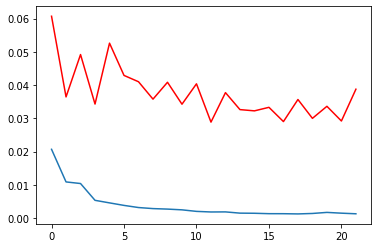

In [165]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"], color="red")

In [166]:
testX = np.expand_dims(scaled[len(scaled)-336:,1:], axis=0)

In [167]:
evaluation = model_1.evaluate(X_test,y_test,verbose=0)
evaluation 

[0.02885371260344982, 0.14837822318077087, 0.02885371260344982]

In [168]:
testX.shape

(1, 336, 122)

In [169]:
X_train[0][X_train[0].shape[0]-336:].shape

(336, 122)

In [170]:
check_up_df = np.expand_dims(X_train[0][X_train[0].shape[0]-336:],axis=0)

In [171]:
check_up_df.shape

(1, 336, 122)

In [172]:
y_train.shape

(64,)

In [173]:
check_up_df_y = trainy[trainy.shape[0]-336:]

In [174]:
check_up_df_y.shape

(336,)

In [275]:
result = model_1.predict(check_up_df)

In [176]:
result.shape

(1, 336)

In [177]:
testy = scaled[len(scaled)-336:,0]

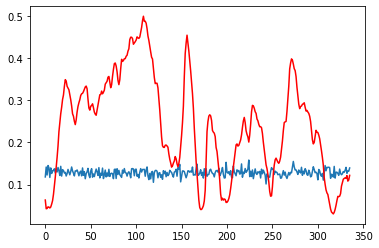

In [276]:
plt.plot(result.flatten())
plt.plot(check_up_df_y, color="red")

In [179]:
result_new_data = model_1.predict(testX)

In [180]:
testy.shape

(336,)

### Testing the MAPE score

In [70]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [87]:
testy = pd.DataFrame(testy)
testy

,0
0,0.292184
1,0.290070
2,0.288929
3,0.288151
4,0.286050
...,...
331,0.062839
332,0.065212
333,0.067495
334,0.073682


In [185]:
res = pd.DataFrame(result.flatten())
res[:][0]

0      0.097468
1      0.109123
2      0.103049
3      0.106965
4      0.116742
         ...   
331    0.107991
332    0.102262
333    0.098739
334    0.104855
335    0.106242
Name: 0, Length: 336, dtype: float32

In [132]:
mean_absolute_percentage_error(testy[0], res[0])

86.74945137187923

validation data richtig benennen

Ideas to improve the model:
Does the split into 64 sequences make sense? Try 32?
try out different stride size in sequencing, maybe even tumbling 
window and no overlapping window

Multiple Layers:

Only use the mean of wind speed?


### Unscaling and Comparing

In [204]:
df_prediction = pd.concat([res, pd.DataFrame(scaled[scaled.shape[0]-336:,1:])], axis=1)

In [205]:
df_prediction

,0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
0,0.097468,0.398417,0.331754,0.197309,0.196809,0.241007,0.176471,0.181287,0.120000,0.103448,0.222222,0.355191,0.157143,0.342020,0.227586,0.224044,0.273256,0.270370,0.101449,0.229008,0.246305,0.211640,0.305455,0.132780,0.195531,0.147059,0.107143,0.309179,0.227778,0.319672,0.236994,0.150685,0.201439,0.140271,0.216080,0.191617,0.203390,0.220077,0.185,0.137931,...,0.074627,0.152542,0.231405,0.038889,0.164706,0.245033,0.085,0.130952,0.249084,0.388298,0.148810,0.193939,0.221239,0.108571,0.172414,0.212355,0.250000,0.324022,0.202454,0.223022,0.340314,0.068323,0.240437,0.051546,0.186567,0.15000,0.116279,0.217054,0.180791,0.244275,0.242424,0.45625,0.124088,0.417266,0.16,0.115741,0.213930,0.197531,0.357143,0.090909
1,0.109123,0.395778,0.293839,0.228700,0.196809,0.215827,0.220588,0.187135,0.155556,0.132184,0.201058,0.311475,0.147619,0.325733,0.234483,0.229508,0.279070,0.303704,0.091787,0.297710,0.241379,0.216931,0.272727,0.132780,0.240223,0.147059,0.112245,0.333333,0.244444,0.262295,0.208092,0.173516,0.201439,0.113122,0.236181,0.215569,0.214689,0.239382,0.190,0.108374,...,0.074627,0.180791,0.243802,0.050000,0.235294,0.264901,0.135,0.172619,0.267399,0.345745,0.130952,0.157576,0.185841,0.108571,0.229885,0.254826,0.202703,0.324022,0.128834,0.237410,0.287958,0.099379,0.267760,0.025773,0.119403,0.15625,0.127907,0.240310,0.135593,0.251908,0.212121,0.46250,0.153285,0.402878,0.15,0.115741,0.233831,0.166667,0.335714,0.058442
2,0.103049,0.416887,0.303318,0.210762,0.234043,0.223022,0.250000,0.087719,0.226667,0.195402,0.126984,0.316940,0.147619,0.335505,0.213793,0.229508,0.302326,0.314815,0.212560,0.358779,0.241379,0.253968,0.261818,0.149378,0.178771,0.169118,0.091837,0.367150,0.233333,0.254098,0.213873,0.164384,0.215827,0.090498,0.195980,0.215569,0.175141,0.220077,0.205,0.147783,...,0.034826,0.180791,0.264463,0.027778,0.317647,0.251656,0.170,0.184524,0.282051,0.377660,0.095238,0.181818,0.194690,0.188571,0.178161,0.254826,0.182432,0.301676,0.171779,0.230216,0.282723,0.130435,0.218579,0.025773,0.126866,0.15625,0.151163,0.271318,0.107345,0.251908,0.252525,0.43750,0.160584,0.410072,0.13,0.115741,0.184080,0.172840,0.314286,0.084416
3,0.106965,0.461741,0.322275,0.192825,0.196809,0.241007,0.220588,0.099415,0.213333,0.195402,0.148148,0.398907,0.147619,0.332248,0.255172,0.262295,0.325581,0.288889,0.280193,0.335878,0.246305,0.248677,0.272727,0.149378,0.167598,0.205882,0.117347,0.352657,0.255556,0.270492,0.208092,0.159817,0.165468,0.099548,0.231156,0.161677,0.186441,0.227799,0.220,0.133005,...,0.034826,0.169492,0.256198,0.033333,0.311765,0.218543,0.140,0.184524,0.263736,0.393617,0.119048,0.200000,0.203540,0.194286,0.212644,0.200772,0.148649,0.296089,0.177914,0.208633,0.261780,0.173913,0.251366,0.025773,0.141791,0.14375,0.145349,0.317829,0.129944,0.381679,0.232323,0.40625,0.197080,0.374101,0.11,0.106481,0.164179,0.172840,0.292857,0.084416
4,0.116742,0.440633,0.431280,0.201794,0.175532,0.266187,0.196078,0.122807,0.217778,0.172414,0.158730,0.360656,0.142857,0.328990,0.262069,0.284153,0.313953,0.303704,0.222222,0.335878,0.290640,0.275132,0.250909,0.170124,0.162011,0.213235,0.107143,0.323671,0.277778,0.245902,0.190751,0.164384,0.115108,0.122172,0.206030,0.149701,0.146893,0.216216,0.240,0.133005,...,0.029851,0.158192,0.243802,0.033333,0.294118,0.158940,0.140,0.196429,0.304029,0.382979,0.178571,0.175758,0.141593,0.182857,0.195402,0.166023,0.202703,0.284916,0.171779,0.179856,0.308901,0.198758,0.224044,0.087629,0.164179,0.16250,0.145349,0.263566,0.158192,0.351145,0.212121,0.41875,0.175182,0.338129,0.06,0.120370,0.154229,0.166667,0.357143,0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [206]:
rev_trans = scaler.inverse_transform(df_prediction)

In [210]:
pd.DataFrame(rev_trans[:,0])

,0
0,7515.005015
1,8413.629044
2,7945.253177
3,8247.204357
4,9001.027896
...,...
331,8326.359040
332,7884.593637
333,7612.936898
334,8084.568199


In [257]:
y_true = pd.DataFrame(filtered_df[0][filtered_df.shape[0]-336:]).reset_index()

In [265]:
y_true

,Date,0
0,2020-12-19 00:00:00,22528.0
1,2020-12-19 01:00:00,22365.0
2,2020-12-19 02:00:00,22277.0
3,2020-12-19 03:00:00,22217.0
4,2020-12-19 04:00:00,22055.0
...,...,...
331,2021-01-01 19:00:00,4845.0
332,2021-01-01 20:00:00,5028.0
333,2021-01-01 21:00:00,5204.0
334,2021-01-01 22:00:00,5681.0


In [248]:
y_pred = pd.DataFrame(rev_trans[:,0])

In [249]:
y_pred

,0
0,7515.005015
1,8413.629044
2,7945.253177
3,8247.204357
4,9001.027896
...,...
331,8326.359040
332,7884.593637
333,7612.936898
334,8084.568199


In [271]:
new_columns = ["True", "Pred"]

In [274]:
df_final = pd.concat([y_true,y_pred], axis=1)

In [ ]:
df_final

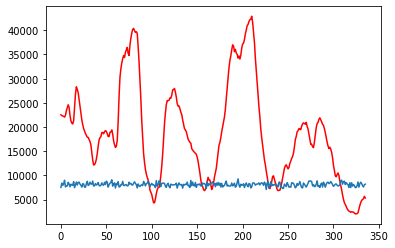

In [259]:
plt.plot(y_true[0],color="red")
plt.plot(y_pred)